From: https://github.com/ksatola/Computational-Statistics

# Is a drug effective or not?

In [1]:
drug = [54, 73, 53, 70, 73, 68, 52, 65, 65] # treatment group
placebo = [54, 51, 58, 44, 55, 52, 42, 47, 58, 46] # control group

$$
H_0 : \mu_{drug} - \mu_{placebo} = 0 \\
H_1 : \mu_{drug} - \mu_{placebo} <> 0
$$
Where:

$ H_0 $ -> **The null hypothesis:** there is no difference in the drug and placebo groups on average (the drug does not have any effect).

$ H_1 $ -> **The alternative hypothesis:** there is a significant difference in the drug and placebo groups on average (the drug works).

I will assume **Type I Error / a significance level (alpha)** at 0.01.

Remarks:
- **Type I Error.** Reject the null hypothesis when there is in fact no significant effect (false positive). The p-value is optimistically small.
- **Type II Error.** Not reject the null hypothesis when there is a significant effect (false negative). The p-value is pessimistically large.

In [2]:
# Significance level
alpha = 0.01

## Analytical Method

In [3]:
import numpy as np

In [4]:
# Means difference of the samples
np.mean(drug) - np.mean(placebo)

12.966666666666661

Is the means difference statistically significant?

We use **T-Student sampling distribution** and calculate **t-test** statistic to find out.

**T-test** assumptions:
1. Both groups (drug and placebo) should be normally distributed
- Samples should come from populations with equal variances
- Samples should be of the same size
- At best there should be more than 20 observations in a sample

### Assumption 1
Both groups (drug and placebo) should be normally distributed

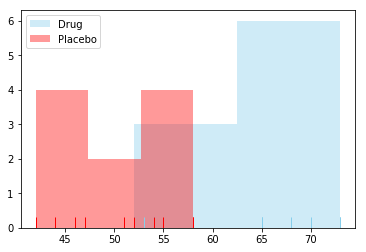

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.distplot(drug, color="skyblue", label="Drug", kde=False, hist=True, rug="True")
sns.distplot(placebo, color="red", label="Placebo", kde=False, hist=True, rug="True")
plt.legend();

In [6]:
from scipy import stats

def normaltest(sample, name, alpha=0.05):
    '''
    Shapiro-Wilk test for samples with n < 50 observations.
    Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
    '''
    W, p = stats.shapiro(sample)
    #print("W = {:g}".format(W))
    #print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: sample comes from a normal distribution
        print("{} does not come from a normal distribution".format(name))
    else:
        print("{} comes from a normal distribution".format(name))

In [7]:
# Is drug normally distributed?
normaltest(drug, "Drug")

Drug comes from a normal distribution


In [8]:
# Is placebo normally distributed?
normaltest(placebo, "Placebo")

Placebo comes from a normal distribution


In [ ]:
# To solve the issue of having too small sample size...
# I could use the following:  (just joking!)
import warnings
warnings.filterwarnings('ignore')

### Assumption 2
Samples should come from populations with equal variances

In [9]:
def varsequals(sample1, sample2, alpha=0.01):
    '''
    Perform Bartlett’s test for equal variances.
    Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.
    Reference: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.bartlett.html
    ''' 
    T, p = stats.bartlett(sample1, sample2)
    #print("T = {:g}".format(T))
    #print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: all input samples are from populations with equal variances
        print("Not all input samples are from populations with equal variances.")
    else:
        print("All input samples are from populations with equal variances.")

In [10]:
varsequals(drug, placebo)

All input samples are from populations with equal variances.


### Calculate t-statistic
Are our samples expected to have been drawn from the same population?

In [11]:
# p-value: Probability of obtaining a result equal to or more extreme than was observed in the data.
t_stat, p = stats.ttest_ind(drug, placebo) # all observations are independent
print('t={:.4f}, p={:.4f}'.format(t_stat, p))

t=3.9357, p=0.0011


In [12]:
# Calculate degrees of freedom
df = len(drug) + len(placebo) - 2
df

17

In [13]:
alpha

0.01

In [14]:
# Calculate the critical value (two-tailed test)
# PPF (percent point function)
cv = stats.t.ppf(1.0 - alpha/2, df)
print(cv)

# Confirm cv with CDF (cumulative distribution function)
#p = stats.t.cdf(cv, df)
#print(p)

2.8982305196347173


<center><img src="images/t_table.jpeg" width="70%"/></center>

In [15]:
# Interpret via critical value (abs for symmetric distribution)
if abs(t_stat) <= cv:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

Reject the null hypothesis that the means are equal.


In [16]:
# Interpret via p-value
if p < alpha:
    print('Reject the null hypothesis that the means are equal.')
else:
    print('Accept null hypothesis that the means are equal.')

Reject the null hypothesis that the means are equal.


### Hypothesis test result
We have sufficient evidence to reject **the null hypothesis** which means the drug works.

## Permutation Testing (Computational Method)

In [17]:
# Python's statitics module provides functions 
# for calculating mathematical statistics of numeric (real-valued) data
from statistics import mean
from random import shuffle

In [ ]:
mean?

In [18]:
observed_diff = mean(drug) - mean(placebo)

print(mean(drug))
print(mean(placebo))

print(f"{observed_diff:.2f}")

63.666666666666664
50.7
12.97


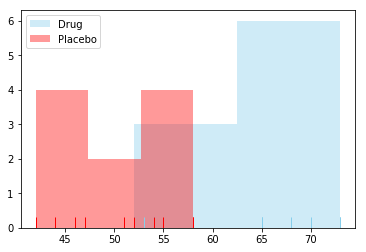

In [19]:
# Always visually inspect your data
import matplotlib.pylab as plt
import seaborn as sns # A library for statical plotting

%matplotlib inline

sns.distplot(drug, color="skyblue", label="Drug", kde=False, hist=True, rug="True");
sns.distplot(placebo, color="red", label="Placebo", kde=False, hist=True, rug="True");
plt.legend(); # Seaborn plots are interoperatable with matplotlib

#### What would it look if there were no difference in the groups?
#### That is the same if take the data and shuffled labels.

Let's assume there is no difference in means of the treatment and control group. If so, we can merge the observations from both groups and we can check how likely is that the observed_diff value or greater appears if there is no difference in the groups.

Let's check how likely is for our observed_diff value or greater to exist when doing random groups assignment from the common pool many times. If the null hypothesis is true (the drug does not work, on average group means are close to 0) we should observe many occurences of mean differences equal or greater to observed_diff. If not, then we can safely reject the null hypothesis.

In [20]:
drug, placebo

([54, 73, 53, 70, 73, 68, 52, 65, 65],
 [54, 51, 58, 44, 55, 52, 42, 47, 58, 46])

In [21]:
# Unite the data
combined = drug + placebo
combined

[54, 73, 53, 70, 73, 68, 52, 65, 65, 54, 51, 58, 44, 55, 52, 42, 47, 58, 46]

In [ ]:
shuffle?

In [22]:
shuffle(combined) # Rearrange in-place
combined

[52, 58, 68, 55, 65, 46, 53, 44, 73, 70, 52, 54, 51, 54, 42, 73, 58, 65, 47]

[52, 58, 68, 55, 65, 46, 53, 44, 73]
[70, 52, 54, 51, 54, 42, 73, 58, 65, 47]


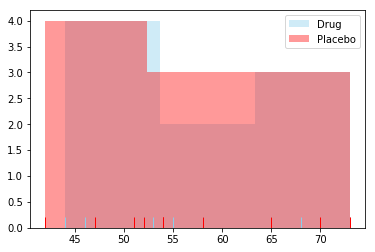

In [23]:
# Randomly assign to drug and placebo group
drug_random = combined[:len(drug)]
placebo_random = combined[len(drug):]

print(drug_random)
print(placebo_random)

sns.distplot(drug_random, color="skyblue", label="Drug", kde=False, hist=True, rug="True");
sns.distplot(placebo_random, color="red", label="Placebo", kde=False, hist=True, rug="True");
plt.legend();

In [24]:
# Simulate it a bunch of times
n = 10_000
count = 0
simulated_means = []

for _ in range(n):
    shuffle(combined)
    shuffled_diff = mean(combined[:len(drug)]) - mean(combined[len(drug):])
    simulated_means.append(shuffled_diff)
    count += (shuffled_diff >= observed_diff)

In [25]:
print(f"""{n:,} label reshufflings produced only {count} instances 
with a difference at least as extreme as the observed difference of {observed_diff:.2f}.""")

10,000 label reshufflings produced only 12 instances 
with a difference at least as extreme as the observed difference of 12.97.


In [26]:
# The p-value is a chance of observing the current difference when there is truly no difference.
# Probability of obtaining a result equal to or more extreme than was observed in the data.
p = count / n
p

0.0012

In [27]:
print("alpha={}, p-value={}".format(alpha,p))

alpha=0.01, p-value=0.0012


In [28]:
# Interpret via p-value
if p < alpha:
    print('Reject the null hypothesis that the means are equal.')
else:
    print('Accept null hypothesis that the means are equal.')

Reject the null hypothesis that the means are equal.


<center><img src="images/p_values.png" width="30%"/></center>

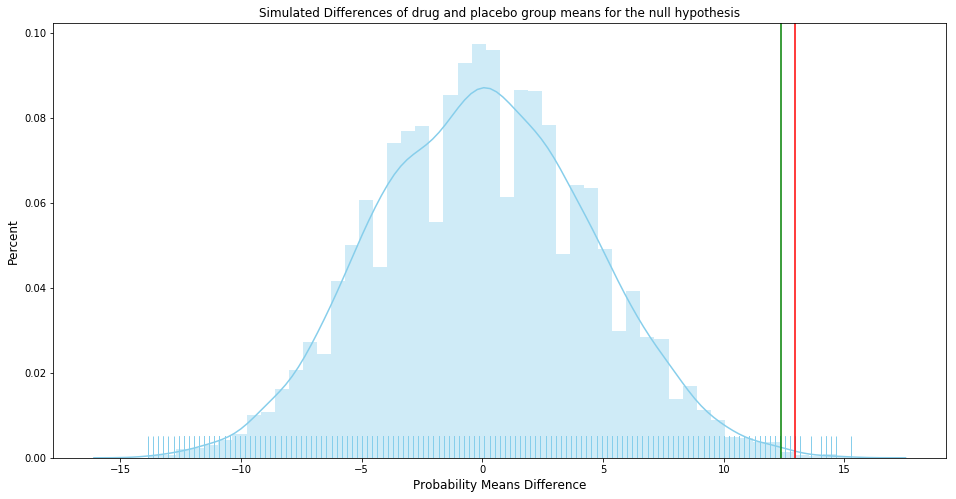

In [29]:
# Interpret visually

# Find the quantile for the alpha/2 cutoff (two-tailed test)
cv = np.max(simulated_means) - stats.t.ppf(1.0 - alpha/2, df)

simulated_means = np.asarray(simulated_means)
plt.figure(figsize=(16, 8))
sns.distplot(simulated_means, color="skyblue", kde=True, hist=True, rug="True")
plt.title("Simulated Differences of drug and placebo group means for the null hypothesis", fontsize=12)
plt.xlabel("Probability Means Difference", fontsize=12)
plt.ylabel("Percent", fontsize=12)
plt.axvline(cv, color='g'); # critical value
plt.axvline(observed_diff, color='r'); # observed mean difference

### Permutation test result
It is very unlikely that the observed_diff value or greater appeared if there is no difference in the groups, so **there is a difference between the drug and the placebo groups**. We have sufficient evidence to reject the null hypothesis, and conclude that the drug is effective.

In [ ]:
from scipy.stats import norm

def tstatistic(sample1, sample2, alpha, one_tail):
    '''
    Calculate t-statistic for 2 samples
    Are the two samples expected to have been drawn from the same population?
    '''
    # Calculate means
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    
    # Calculate sample standard deviations
    std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    
    # Calculate standard errors
    n1, n2 = len(sample1), len(sample2)
    se1, se2 = std1/np.sqrt(n1), std2/np.sqrt(n2)

    # Standard error on the difference between the samples
    sed = np.sqrt(se1**2.0 + se2**2.0)
    
    # Calculate degrees of freedom
    df = len(sample1) + len(sample2) - 2
    
    # Calculate the t statistic
    t_stat = (mean1 - mean2) / sed
    
    # Calculate the critical value
    if one_tail:
        cv = stats.t.ppf(1.0 - alpha, df)
    else:
        cv = stats.t.ppf(1.0 - alpha/2, df) # 2-tailed
    
    # Calculate the p-value
    p = (1.0 - stats.t.cdf(abs(t_stat), df)) * 2.0
    
    return t_stat, df, cv, p

In [ ]:
t, df, cv, p = tstatistic(drug, placebo, alpha, one_tail=False)
t, df, cv, p